# EEGNet: Motor Imagery Classification

## Subject-Dependent vs Subject-Independent Training Comparison

This notebook compares two training strategies for BCI motor imagery classification using the **EEGNet** architecture:

1. **Subject-Dependent Training**: Train separate model for each subject using cross-validation
2. **Subject-Independent Training**: Leave-One-Subject-Out (LOSO) cross-validation

## Overview

### EEGNet Architecture
EEGNet is a compact convolutional neural network designed for EEG-based brain-computer interfaces (Lawhern et al., 2018):
- Uses **depthwise and separable convolutions** to efficiently capture spatial and temporal features
- Compact architecture with relatively few parameters (~1,500 parameters)
- Well-suited for motor imagery classification tasks

### Dataset: BCI Competition IV-2b
- **Subjects**: 9 subjects (B01-B09)
- **Channels**: 3 EEG channels (Cz, C3, C4)
- **Sampling Rate**: 250 Hz
- **Task**: Binary motor imagery classification (Left hand vs Right hand)
- **Trial Duration**: 4.5 seconds ([2.5, 7.0] seconds relative to cue)

### Data Preprocessing Pipeline
Following the preprocessing pipeline from CTNet notebook:
- **Bandpass Filtering**: 4-40 Hz
- **Notch Filtering**: 50 Hz (power line noise removal)
- **Per-Electrode Standardization**: Z-score normalization per channel
- **Epoch Extraction**: [2.5, 7.0] seconds (1125 samples at 250 Hz)

## Objectives

- Train EEGNet models using both strategies
- Compare accuracy performance between subject-dependent and subject-independent approaches
- Visualize results with comparative plots
- Analyze per-subject performance differences
- Provide insights for practical BCI applications


In [1]:
# Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import mne
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import shutil
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML
from typing import Tuple, Dict, Optional
from tqdm import tqdm

# Add parent directory to path for imports
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'app'))

# Import organized modules
from app.models import EEGNet
from app.datasets import EEGDataLoader, MNEEpochsDataset, get_all_epochs

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", module='mne')

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("=" * 60)
print("Imports and Setup Complete")
print("=" * 60)
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print(f"Random seed: {RANDOM_SEED}")
print("=" * 60)


Imports and Setup Complete
PyTorch version: 2.9.0+cu128
Device: cuda
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Random seed: 42


## 1. Model Architecture: EEGNet

Define the EEGNet architecture for motor imagery classification.


In [2]:
"""
EEGNet: Compact Convolutional Neural Network for EEG Classification
Implementation based on Lawhern et al. (2018).

Paper: EEGNet: A Compact Convolutional Neural Network for EEG-based Brain-Computer Interfaces
Architecture: Temporal Conv → Depthwise Conv → Separable Conv → Classification
"""

class EEGNet(nn.Module):
    """
    EEGNet: Compact Convolutional Neural Network for EEG Classification.
    
    Architecture (Lawhern et al., 2018):
    - Block 1: Temporal Conv → Depthwise Conv → Separable Conv → AvgPool
    - Block 2: Depthwise Conv → Separable Conv → AvgPool
    - Classification: Dense layer with dropout
    
    Args:
        num_channels: Number of EEG channels (3 for BCI IV-2b)
        num_classes: Number of classes (2 for left/right hand)
        F1: Number of temporal filters (default 8)
        F2: Number of pointwise filters (default 16)
        D: Number of spatial filters per temporal filter (default 2)
        kernel_length: Length of temporal convolution kernel (default 64)
        pool_time: Pooling size in time dimension (default 4)
        pool_space: Pooling size in space dimension (default 1)
        dropout_rate: Dropout rate (default 0.5)
    """
    
    def __init__(self, 
                 num_channels=3,
                 num_classes=2,
                 F1=8,
                 F2=16,
                 D=2,
                 kernel_length=64,
                 pool_time=4,
                 pool_space=1,
                 dropout_rate=0.5):
        super().__init__()
        
        # Block 1: Temporal Convolution
        self.conv_temporal = nn.Conv2d(1, F1, (1, kernel_length), 
                                       padding=(0, kernel_length // 2), bias=False)
        self.bn1 = nn.BatchNorm2d(F1)
        
        # Block 1: Depthwise Convolution (spatial)
        self.conv_spatial = nn.Conv2d(F1, D * F1, (num_channels, 1), 
                                      groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(D * F1)
        self.elu1 = nn.ELU()
        self.pool1 = nn.AvgPool2d((pool_space, pool_time))
        self.drop1 = nn.Dropout(dropout_rate)
        
        # Block 2: Separable Convolution (depthwise + pointwise)
        self.conv_separable_depth = nn.Conv2d(D * F1, D * F1, (1, 16),
                                               groups=D * F1, padding=(0, 8), bias=False)
        self.conv_separable_point = nn.Conv2d(D * F1, F2, (1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(F2)
        self.elu2 = nn.ELU()
        self.pool2 = nn.AvgPool2d((1, 8))
        self.drop2 = nn.Dropout(dropout_rate)
        
        # Classification - use global average pooling for flexibility
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(F2, num_classes, bias=True)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, channels, time)
        
        Returns:
            output: Class logits of shape (batch, num_classes)
        """
        # Handle input shape: (batch, channels, time) -> (batch, 1, channels, time)
        if x.dim() == 3:
            x = x.unsqueeze(1)
        
        # Block 1: Temporal Convolution
        x = self.conv_temporal(x)
        x = self.bn1(x)
        
        # Block 1: Depthwise Spatial Convolution
        x = self.conv_spatial(x)
        x = self.bn2(x)
        x = self.elu1(x)
        x = self.pool1(x)
        x = self.drop1(x)
        
        # Block 2: Separable Convolution
        x = self.conv_separable_depth(x)
        x = self.conv_separable_point(x)
        x = self.bn3(x)
        x = self.elu2(x)
        x = self.pool2(x)
        x = self.drop2(x)
        
        # Global average pooling: (batch, F2, 1, time) -> (batch, F2, 1, 1)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # (batch, F2)
        
        # Classification
        output = self.classifier(x)
        return output


# Test the model
test_model = EEGNet(num_channels=3, num_classes=2).to(device)
total_params = sum(p.numel() for p in test_model.parameters())
trainable_params = sum(p.numel() for p in test_model.parameters() if p.requires_grad)

print("=" * 60)
print("EEGNet Model Definition")
print("=" * 60)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
test_input = torch.randn(4, 3, 1125).to(device)
test_output = test_model(test_input)
print(f"\nTest forward pass:")
print(f"  Input shape: {test_input.shape}")
print(f"  Output shape: {test_output.shape}")
print(f"  ✅ Model works correctly!")
print("=" * 60)


EEGNet Model Definition
Total parameters: 1,186
Trainable parameters: 1,186

Test forward pass:
  Input shape: torch.Size([4, 3, 1125])
  Output shape: torch.Size([4, 2])
  ✅ Model works correctly!


In [3]:
import os
import re
import mne
import numpy as np
class EEGDataLoader:
    def __init__(self, data_folder='../data/BCICIV_2b_gdf', file_filters=None, 
                 raw_channels=['EEG:Cz', 'EEG:C3', 'EEG:C4'], 
                 channel_fun=lambda x: x.replace('EEG:', ''), 
                 filtered=True,
                 apply_standardization=True,
                 standardization_scope='session',
                 filter_range=(4, 40),
                 apply_notch=True,
                 notch_freq=50):
        """
        Enhanced EEGDataLoader for BCI Competition IV-2b dataset.
        
        Args:
            data_folder: Path to folder containing GDF files
            file_filters: Optional filters for file selection
            raw_channels: List of raw channel names
            channel_fun: Function to transform channel names
            filtered: Whether to apply filtering (legacy, use filter_range instead)
            apply_standardization: Whether to apply electrode-wise standardization
            standardization_scope: Scope for standardization ('session' or 'subject')
            filter_range: Tuple (low_freq, high_freq) for bandpass filter
            apply_notch: Whether to apply notch filter
            notch_freq: Frequency for notch filter (default 50 Hz)
        """
        self.filename_pattern = r"^(B\d{2})(\d{2})([A-Za-z])\.gdf$"
        self.data_folder = data_folder
        self.file_filters = file_filters
        self.data_dir_info = self._scan_data_dir_(self.file_filters)
        self._data_cache = {}
        self.filter = filtered
        self.apply_standardization = apply_standardization
        self.standardization_scope = standardization_scope
        self.filter_range = filter_range
        self.apply_notch = apply_notch
        self.notch_freq = notch_freq
        self.raw_channels = raw_channels
        if channel_fun:
            self.channels = [channel_fun(ch) for ch in self.raw_channels]
        else:
            self.channels = self.raw_channels
        self.channel_mapping = {raw: ch for raw, ch in zip(self.raw_channels, self.channels)}
        self.rename_map = {
            '769': 'left',
            '770': 'right',
            '768': 'start_trial',
            '1023': 'rejected_trial',
            '32766': 'run_start'
        }
        # Cache for standardization statistics
        self._standardization_stats = {}
    def _scan_data_dir_(self, filters=None):
        files = [f for f in os.listdir(self.data_folder) if f.endswith('.gdf')]
        info = []
        for filename in files:
            match = re.match(self.filename_pattern, filename)
            if match:
                subj, sess, stype = match.groups()
                # Apply filters if provided
                if filters:
                    if 'subject_ids' in filters and subj not in filters['subject_ids']:
                        continue
                    if 'session_ids' in filters and sess not in filters['session_ids']:
                        continue
                    if 'session_types' in filters and stype not in filters['session_types']:
                        continue
                info.append({
                    "subject_id": subj,
                    "session_id": sess,
                    "session_type": stype,
                    "filename": filename
                })
        return info
    def list_subjects(self):
        return sorted(set(x["subject_id"] for x in self.data_dir_info))
    def list_sessions(self, subject_id):
        return sorted(set(x["session_id"] for x in self.data_dir_info if x["subject_id"] == subject_id))
    def list_session_types(self, subject_id, session_id):
        return sorted(set(x["session_type"] for x in self.data_dir_info
                         if x["subject_id"] == subject_id and x["session_id"] == session_id))
    def get_available(self):
        '''Return a list of all available (subject, session, session_type, session_type)'''
        return [(x["subject_id"], x["session_id"], x["session_type"], x["session_type"]) for x in self.data_dir_info]
    def _load_eeg_data_(self, subject_id, session_id, session_type):
        """
        Load EEG data for a given subject/session/type from a GDF file.
        Filters signals, extracts MI events, removes rejected trials,
        and returns epochs (overall + per run) with only selected EEG channels.
        """
        # ----------------------------------------------------
        # Load file
        # ----------------------------------------------------
        file_path = os.path.join(self.data_folder, f"{subject_id}{session_id}{session_type}.gdf")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        raw = mne.io.read_raw_gdf(file_path, preload=True, verbose=False)
        raw.rename_channels(self.channel_mapping)
        for ch in raw.ch_names:
            if ch.startswith('EOG'):
                raw.set_channel_types({ch: 'eog'})
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage, match_case=False)
        # ----------------------------------------------------
        # Preprocessing
        # ----------------------------------------------------
        if self.filter:
            # Use configurable filter range
            low_freq, high_freq = self.filter_range
            raw.filter(low_freq, high_freq, verbose=False)
            if self.apply_notch:
                raw.notch_filter(self.notch_freq, verbose=False)
        # ----------------------------------------------------
        # Channel selection
        # ----------------------------------------------------
        available_channels = []
        for ch in self.channels:
            if ch in raw.ch_names:
                available_channels.append(ch)
            elif f"EEG:{ch}" in raw.ch_names:
                available_channels.append(f"EEG:{ch}")
        if not available_channels:
            raise ValueError(f"None of the requested channels {self.channels} found in {file_path}")
        raw.pick_channels(available_channels)
        picks = mne.pick_channels(raw.info["ch_names"], include=available_channels)
        # ----------------------------------------------------
        # Extract events
        # ----------------------------------------------------
        events, event_dict = mne.events_from_annotations(raw)
        try:
            start_trial_code = event_dict['768']
            left_code = event_dict['769']
            right_code = event_dict['770']
            rejected_code = event_dict['1023']
            run_start_code = event_dict['32766']
        except KeyError:
            return {'raw': raw, 'epochs': None, 'epochs_per_run': None}
        # ----------------------------------------------------
        # Identify valid MI trials
        # ----------------------------------------------------
        trial_starts = events[events[:, 2] == start_trial_code][:, 0]
        rejected_starts = set(events[events[:, 2] == rejected_code][:, 0])
        mi_events = events[np.isin(events[:, 2], [left_code, right_code])]
        run_starts = events[events[:, 2] == run_start_code][:, 0]
        run_starts = np.append(run_starts, [raw.n_times])
        valid_mi_events = []
        for mi_event in mi_events:
            trial_start = trial_starts[trial_starts <= mi_event[0]].max()
            if trial_start not in rejected_starts:
                valid_mi_events.append(mi_event)
        valid_mi_events = np.array(valid_mi_events)
        # ----------------------------------------------------
        # Standardize event IDs
        # ----------------------------------------------------
        standard_event_id = {'left': 1, 'right': 2}
        remapped_events = valid_mi_events.copy()
        remapped_events[:, 2][remapped_events[:, 2] == left_code] = standard_event_id['left']
        remapped_events[:, 2][remapped_events[:, 2] == right_code] = standard_event_id['right']
        # ----------------------------------------------------
        # Create epochs
        # Paper: BCI IV-2b uses [2.5, 7] seconds relative to cue
        # tmin=2.5, tmax=7.0 (4.5 seconds = 1125 samples at 250Hz)
        # ----------------------------------------------------
        epochs = mne.Epochs(
            raw, remapped_events, standard_event_id,
            picks=picks, tmin=2.5, tmax=7.0,
            preload=True, baseline=None, verbose=False
        )
        # ----------------------------------------------------
        # Create epochs per run
        # ----------------------------------------------------
        epochs_per_run = {}
        for i in range(len(run_starts) - 1):
            run_start = run_starts[i]
            run_end = run_starts[i + 1]
            run_events = remapped_events[(remapped_events[:, 0] >= run_start) &
                                           (remapped_events[:, 0] < run_end)]
            if len(run_events) > 0:
                run_epochs = mne.Epochs(
                    raw, run_events, standard_event_id,
                    picks=picks, tmin=2.5, tmax=7.0,
                    preload=True, baseline=None, verbose=False
                )
                epochs_per_run[i + 1] = run_epochs
        return {
            'raw': raw,
            'epochs': epochs,
            'epochs_per_run': epochs_per_run,
            'event_dict' : event_dict
        }
    def get_data(self, subject_id, session_id, session_type, reload=False):
        key = (subject_id, session_id, session_type)
        if not reload and key in self._data_cache:
            return self._data_cache[key]
        data = self._load_eeg_data_(subject_id, session_id, session_type)
        self._data_cache[key] = data
        return data
    
    def _standardize_data(self, X_train, X_test, subject_id=None, eps=1e-8):
        """
        Private method to standardize data using training statistics only.
        
        Args:
            X_train: Training data of shape (n_trials, n_channels, n_times)
            X_test: Test data of shape (n_trials, n_channels, n_times)
            subject_id: Subject ID for caching statistics (optional)
            eps: Small epsilon to avoid division by zero
            
        Returns:
            X_train_std: Standardized training data
            X_test_std: Standardized test data
            stats: Dictionary with mean and std per channel
        """
        # Compute mean and std per channel across all training trials
        mean_per_channel = np.mean(X_train, axis=(0, 2), keepdims=True)
        std_per_channel = np.std(X_train, axis=(0, 2), keepdims=True)
        
        # Add epsilon to avoid division by zero
        std_per_channel = np.maximum(std_per_channel, eps)
        
        # Standardize training data
        X_train_std = (X_train - mean_per_channel) / std_per_channel
        
        # Standardize test data using training statistics (prevents data leakage)
        X_test_std = (X_test - mean_per_channel) / std_per_channel
        
        # Store statistics
        stats = {
            'mean': mean_per_channel.squeeze(),  # (n_channels,)
            'std': std_per_channel.squeeze()      # (n_channels,)
        }
        
        # Cache statistics if subject_id provided
        if subject_id:
            self._standardization_stats[subject_id] = stats
        
        return X_train_std, X_test_std, stats
    
    def get_train_test_split(self, subject_id, apply_standardization=None):
        """
        Get train/test split for BCI Competition IV-2b dataset following official protocol.
        
        Uses only training sessions (01T, 02T, 03T) and splits them into train/test sets.
        
        Args:
            subject_id: Subject ID (e.g., 'B01')
            apply_standardization: Override default standardization setting (optional)
            
        Returns:
            X_train: Training data (n_trials, n_channels, n_times)
            y_train: Training labels (0-indexed: 0=left, 1=right)
            X_test: Test data (n_trials, n_channels, n_times)
            y_test: Test labels (0-indexed: 0=left, 1=right)
            stats: Standardization statistics (if applied)
        """
        # Use provided standardization setting or default
        standardize = apply_standardization if apply_standardization is not None else self.apply_standardization
        
        # Load training sessions (1, 2, 3 with type 'T')
        train_epochs_list = []
        for session_id in ['01', '02', '03']:
            try:
                data = self.get_data(subject_id, session_id, 'T')
                if data['epochs'] is not None and len(data['epochs']) > 0:
                    train_epochs_list.append(data['epochs'])
            except FileNotFoundError:
                print(f"Warning: Training session {session_id}T not found for {subject_id}")
            except Exception as e:
                print(f"Warning: Error loading session {session_id}T for {subject_id}: {e}")
        
        if not train_epochs_list:
            raise ValueError(f"No training data found for subject {subject_id}")
        
        # Concatenate training epochs
        train_epochs = mne.concatenate_epochs(train_epochs_list) if len(train_epochs_list) > 1 else train_epochs_list[0]
        
        # Split training data into train/test sets using sklearn
        from sklearn.model_selection import train_test_split
        
        # Extract all data and labels from training sessions
        X_all = train_epochs.get_data(copy=False)  # (n_trials, n_channels, n_times)
        y_all = train_epochs.events[:, -1] - 1  # Convert to 0-indexed (1->0, 2->1)
        
        # Split into train/test (70/30 split, stratified)
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, test_size=0.3, random_state=42, stratify=y_all
        )
        
        
        # Apply standardization if requested
        stats = None
        if standardize:
            X_train, X_test, stats = self._standardize_data(X_train, X_test, subject_id)
        
        return X_train, y_train, X_test, y_test, stats
    
    def validate_data(self, subject_id, apply_standardization=None):
        """
        Validate and print information about train/test data for a subject.
        
        Args:
            subject_id: Subject ID (e.g., 'B01')
            apply_standardization: Override default standardization setting (optional)
            
        Returns:
            X_train, y_train, X_test, y_test: Data arrays for immediate use
        """
        print(f"\n=== Data Validation for Subject {subject_id} ===\n")
        
        # Get train/test split
        try:
            X_train, y_train, X_test, y_test, stats = self.get_train_test_split(
                subject_id, apply_standardization=apply_standardization
            )
        except Exception as e:
            print(f"Error loading data: {e}")
            return None, None, None, None
        
        # Print shapes
        print(f"Training Data Shape: {X_train.shape}")
        print(f"Training Labels Shape: {y_train.shape}")
        print(f"Test Data Shape: {X_test.shape}")
        print(f"Test Labels Shape: {y_test.shape}\n")
        
        # Print class distribution
        train_counts = np.bincount(y_train)
        test_counts = np.bincount(y_test)
        print(f"Training Class Distribution:")
        print(f"  Left hand (class 0): {train_counts[0]} trials")
        print(f"  Right hand (class 1): {train_counts[1]} trials")
        print(f"  Total: {len(y_train)} trials\n")
        
        print(f"Test Class Distribution:")
        print(f"  Left hand (class 0): {test_counts[0]} trials")
        print(f"  Right hand (class 1): {test_counts[1]} trials")
        print(f"  Total: {len(y_test)} trials\n")
        
        # Verify time samples (should be 1125 for 4.5 seconds at 250 Hz)
        expected_timepoints = 1125
        actual_timepoints = X_train.shape[2]
        if actual_timepoints == expected_timepoints:
            print(f"✓ Time samples: {actual_timepoints} (matches expected {expected_timepoints})\n")
        else:
            print(f"⚠ Time samples: {actual_timepoints} (expected {expected_timepoints})\n")
        
        # Print standardization statistics if applied
        if stats is not None:
            print(f"Standardization Statistics (from training data):")
            print(f"  Mean per channel: {stats['mean']}")
            print(f"  Std per channel: {stats['std']}\n")
            
            # Print mean/std of standardized data
            print(f"Standardized Data Statistics:")
            print(f"  Training data mean: {X_train.mean():.6f}, std: {X_train.std():.6f}")
            print(f"  Test data mean: {X_test.mean():.6f}, std: {X_test.std():.6f}\n")
        else:
            print(f"Standardization: Not applied\n")
        
        print(f"=== Validation Complete ===\n")
        
        return X_train, y_train, X_test, y_test
    
    def get_pytorch_loaders(self, subject_id, batch_size=64, num_workers=0, 
                           shuffle_train=True, apply_standardization=None):
        """
        Get PyTorch DataLoaders for training and testing.
        
        Args:
            subject_id: Subject ID (e.g., 'B01')
            batch_size: Batch size for DataLoaders (default 64)
            num_workers: Number of worker processes for data loading (default 0)
            shuffle_train: Whether to shuffle training data (default True)
            apply_standardization: Override default standardization setting (optional)
            
        Returns:
            train_loader: PyTorch DataLoader for training
            test_loader: PyTorch DataLoader for testing
        """
        # Get train/test split
        X_train, y_train, X_test, y_test, stats = self.get_train_test_split(
            subject_id, apply_standardization=apply_standardization
        )
        
        # Create PyTorch datasets
        train_dataset = MNEEpochsDataset(X_train, y_train)
        test_dataset = MNEEpochsDataset(X_test, y_test)
        
        # Create DataLoaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=shuffle_train,
            num_workers=num_workers
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,  # Never shuffle test data
            num_workers=num_workers
        )
        
        return train_loader, test_loader

In [4]:
# Import data utilities
from app.utils.data_utils import get_all_epochs, MNEEpochsDataset, standardize_signals, standardize_signals_using_stats

# Initialize data loader with preprocessing from CTNet notebook
data_loader = EEGDataLoader(
    data_folder='../data/BCICIV_2b_gdf',
    raw_channels=['EEG:Cz', 'EEG:C3', 'EEG:C4'],
    channel_fun=lambda x: x.replace('EEG:', ''),
    filtered=True,
    apply_standardization=True,
    filter_range=(4, 40),  # Bandpass filter: 4-40 Hz
    apply_notch=True,      # Notch filter: 50 Hz
    notch_freq=50
)

# List available subjects
all_subjects = data_loader.list_subjects()

print("=" * 60)
print("Data Loader Initialized")
print("=" * 60)
print(f"Available subjects: {all_subjects}")
print(f"Total subjects: {len(all_subjects)}")
print(f"Data folder: {data_loader.data_folder}")
print(f"Channels: {data_loader.channels}")
print(f"Preprocessing:")
print(f"  - Bandpass filter: {data_loader.filter_range} Hz")
print(f"  - Notch filter: {data_loader.notch_freq} Hz" if data_loader.apply_notch else "  - Notch filter: Disabled")
print(f"  - Standardization: {'Enabled' if data_loader.apply_standardization else 'Disabled'}")
print("=" * 60)


Data Loader Initialized
Available subjects: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09']
Total subjects: 9
Data folder: ../data/BCICIV_2b_gdf
Channels: ['Cz', 'C3', 'C4']
Preprocessing:
  - Bandpass filter: (4, 40) Hz
  - Notch filter: 50 Hz
  - Standardization: Enabled


## 3. Training Configuration

Set hyperparameters and training configuration for EEGNet model.


In [5]:
# Import training utilities
from app.scripts.train import run_training
from app.utils.early_stopping import EarlyStopping

# EEGNet Model Configuration
# Based on Lawhern et al. (2018) paper
MODEL_KWARGS = {
    'num_classes': 2,
    'num_channels': 3,
    'F1': 8,              # Number of temporal filters
    'F2': 16,             # Number of pointwise filters
    'D': 2,               # Number of spatial filters per temporal filter
    'kernel_length': 64,  # Temporal convolution kernel length
    'pool_time': 4,       # Pooling size in time dimension
    'pool_space': 1,      # Pooling size in space dimension
    'dropout_rate': 0.5,  # Dropout rate (default from paper)
}

# Training Configuration
# Following best practices for EEG classification
TRAINING_CONFIG = {
    'epochs': 500,              # Maximum number of epochs
    'batch_size': 64,           # Batch size
    'lr': 0.001,                # Learning rate (Adam optimizer)
    'weight_decay': 1e-4,       # Weight decay for regularization
    'n_splits': 3,              # Number of CV folds for subject-dependent training
    'val_size': 0.2,            # Validation set size (20% of training data)
    'early_stopping_patience': 50,  # Early stopping patience
}

print("=" * 60)
print("Training Configuration")
print("=" * 60)
print("Model Configuration (EEGNet):")
for key, value in MODEL_KWARGS.items():
    print(f"  {key}: {value}")
print("\nTraining Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")
print("=" * 60)


Training Configuration
Model Configuration (EEGNet):
  num_classes: 2
  num_channels: 3
  F1: 8
  F2: 16
  D: 2
  kernel_length: 64
  pool_time: 4
  pool_space: 1
  dropout_rate: 0.5

Training Configuration:
  epochs: 500
  batch_size: 64
  lr: 0.001
  weight_decay: 0.0001
  n_splits: 3
  val_size: 0.2
  early_stopping_patience: 50


c:\Users\devdp\anaconda3\envs\brain_to_action\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Subject-Dependent Training

Train separate models for each subject using cross-validation. All sessions per subject are combined before splitting into train/validation sets.


## 3. Subject-Dependent Training with Cross-Validation


In [6]:
def train_subject_dependent_cv_simple(data_loader, subject_ids=None, n_splits=3):
    """
    Subject-dependent training with cross-validation (FIXED VERSION).
     COMBINES ALL 3 RUNS before CV (single model, not 3 separate models)
     Uses 3-fold CV (larger validation sets)
     Uses StratifiedShuffleSplit for better class balance
     Returns average training size for SI to match
    """
    if subject_ids is None:
        subject_ids = data_loader.list_subjects()
    results = []
    training_trial_counts = []  # Track training set sizes
    print(f" Starting Subject-Dependent Training ({n_splits}-Fold CV)")
    print(f" Subjects: {subject_ids}")
    print(f" Combining all runs/sessions per subject before CV\n")
    for subject_id in subject_ids:
        print(f" Training Subject: {subject_id}")
        # Use new pipeline: get training data from sessions 1-3 (following BCI protocol)
        # For subject-dependent CV, we only need training data, not test data
        try:
            # Load training sessions (1, 2, 3 with type 'T')
            train_epochs_list = []
            for session_id in ['01', '02', '03']:
                try:
                    data = data_loader.get_data(subject_id, session_id, 'T')
                    if data['epochs'] is not None and len(data['epochs']) > 0:
                        train_epochs_list.append(data['epochs'])
                except FileNotFoundError:
                    print(f"  Warning: Training session {session_id}T not found for {subject_id}")
                except Exception as e:
                    print(f"  Warning: Error loading session {session_id}T for {subject_id}: {e}")
            
            if not train_epochs_list:
                print(f"  No training data found for {subject_id}, skipping...\n")
                continue
            
            # Concatenate training epochs
            train_epochs = mne.concatenate_epochs(train_epochs_list) if len(train_epochs_list) > 1 else train_epochs_list[0]
            
            # Extract data and labels (no standardization yet - will do per fold)
            X_train_all = train_epochs.get_data(copy=False)  # (n_trials, n_channels, n_times)
            y_train_all = train_epochs.events[:, -1] - 1  # Convert to 0-indexed (1->0, 2->1)
            
        except Exception as e:
            print(f"  Error loading data for {subject_id}: {e}, skipping...\n")
            continue
        
        if X_train_all is None or len(X_train_all) == 0:
            print(f"  No training data found for {subject_id}, skipping...\n")
            continue
        
        eeg_data = X_train_all
        labels = y_train_all
        print(f"   Training data shape: {eeg_data.shape} (sessions 1-3 from BCI protocol)")
        print(f"   Class distribution: {np.bincount(labels)}")
        # Check class balance
        class_balance = np.bincount(labels)
        imbalance = abs(class_balance[0] - class_balance[1]) / len(labels) * 100
        if imbalance > 10:
            print(f"     Class imbalance: {imbalance:.1f}%")
        # Use StratifiedShuffleSplit for better class balance in validation sets
        sss = StratifiedShuffleSplit(
            n_splits=n_splits, 
            test_size=TRAINING_CONFIG['val_size'], 
            random_state=42
        )
        cv_results = []
        for fold, (train_idx, val_idx) in enumerate(sss.split(eeg_data, labels)):
            # Split data
            X_train_fold = eeg_data[train_idx]
            y_train_fold = labels[train_idx]
            X_val_fold = eeg_data[val_idx]
            y_val_fold = labels[val_idx]
            # Standardize signals (paper's preprocessing) - per fold to prevent data leakage
            # Use training statistics for both train and validation
            X_train_fold_std, X_val_fold_std, stats = data_loader._standardize_data(
                X_train_fold, X_val_fold, subject_id=None, eps=1e-8
            )
            # Track training set size
            training_trial_counts.append(len(X_train_fold))
            # Check validation set class balance
            val_balance = np.bincount(y_val_fold)
            val_imbalance = abs(val_balance[0] - val_balance[1]) / len(y_val_fold) * 100
            if val_imbalance > 15:
                print(f"     Fold {fold+1} validation imbalance: {val_imbalance:.1f}%")
            print(f"   Fold {fold+1}: Train={len(X_train_fold)}, Val={len(X_val_fold)}, "
                  f"Val balance: {val_balance}")
            # Create datasets
            train_dataset = MNEEpochsDataset(X_train_fold_std, y_train_fold)
            val_dataset = MNEEpochsDataset(X_val_fold_std, y_val_fold)
            # Initialize model (fresh model for each fold)
            model = EEGNet(**MODEL_KWARGS)
            model.to(device)
            # Optimizer and loss
            optimizer = torch.optim.Adam(
                model.parameters(), 
                lr=TRAINING_CONFIG['lr'], 
                weight_decay=TRAINING_CONFIG['weight_decay']
            )
            criterion = nn.CrossEntropyLoss()
            # Learning rate scheduler
            lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=10
            )
            # Early stopping (paper uses patience=300)
            early_stopping = EarlyStopping(
                monitor='val_loss', 
                mode='min', 
                patience=TRAINING_CONFIG['early_stopping_patience']  # Paper uses 300
            )
            # Train (use temp path for training)
            save_prefix = f"outputs/temp_{subject_id}_fold{fold+1}"
            model, history, best_model_path = run_training(
                model=model,
                train_dataset=train_dataset,
                val_dataset=val_dataset,
                optimizer=optimizer,
                loss_fn=criterion,
                device=device,
                epochs=TRAINING_CONFIG['epochs'],
                batch_size=TRAINING_CONFIG['batch_size'],
                save_prefix=save_prefix,
                scheduler=lr_scheduler,
                early_stopping=early_stopping,
            )
            # Evaluate on validation set
            model.eval()
            val_preds = []
            val_labels = []
            val_loader = DataLoader(val_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False)
            with torch.no_grad():
                for x, y in val_loader:
                    x = x.to(device)
                    logits = model(x)
                    preds = logits.argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(y.numpy())
            val_acc = accuracy_score(val_labels, val_preds)
            cv_results.append({
                'fold': fold + 1,
                'val_acc': val_acc,
                'n_train': len(X_train_fold),
                'n_val': len(X_val_fold),
                'best_model_path': best_model_path,
            })
            results.append({
                'subject': subject_id,
                'fold': fold + 1,
                'val_acc': val_acc,
                'n_train': len(X_train_fold),
                'strategy': 'Subject-Dependent'
            })
        # Summary for this subject
        cv_df = pd.DataFrame(cv_results)
        mean_acc = cv_df['val_acc'].mean()
        std_acc = cv_df['val_acc'].std()
        mean_train_size = cv_df['n_train'].mean()
        
        # Save best model from best fold to ../app/resources/models/{subject_id}/best_model.pth
        best_fold_idx = cv_df['val_acc'].idxmax()
        best_fold_model_path = cv_df.loc[best_fold_idx, 'best_model_path']
        model_save_dir = f"../app/resources/models/{subject_id}"
        os.makedirs(model_save_dir, exist_ok=True)
        final_model_path = os.path.join(model_save_dir, "best_model.pth")
        
        # Copy best model to final location
        shutil.copy2(best_fold_model_path, final_model_path)
        print(f"    Best model saved: {final_model_path} (from fold {cv_df.loc[best_fold_idx, 'fold']})")
        
        print(f"    CV Results - Acc: {mean_acc:.4f} ± {std_acc:.4f}")
        print(f"    Mean training size: {mean_train_size:.0f} trials\n")
    # Store average training size for SI to match
    avg_training_size = int(np.mean(training_trial_counts)) if training_trial_counts else None
    print(f" Average training size per fold: {avg_training_size} trials")
    print(f"   (SI will use this same size for fair comparison)\n")
    return pd.DataFrame(results), avg_training_size
print(" Training function defined")

 Training function defined


In [7]:
# Run subject-dependent training
# Note: This may take a while. For faster execution, you can reduce n_splits or epochs
print("Starting Subject-Dependent Training...")
subject_dependent_results, avg_sd_training_size = train_subject_dependent_cv_simple(
    data_loader, 
    subject_ids=all_subjects,  # Start with 3 subjects for demo (change to all_subjects for full run)
    n_splits=TRAINING_CONFIG['n_splits']
)
print(f"\n Subject-Dependent Training Complete")
print(f"Average training size per fold: {avg_sd_training_size} trials")
print(f"   (Subject-Independent will use {avg_sd_training_size} trials for fair comparison)")
print(f"Average training size per fold: {avg_sd_training_size} trials")
print(f"   (Subject-Independent will use {avg_sd_training_size} trials for fair comparison)")
print(f"Average training size per fold: {avg_sd_training_size} trials")
print(f"   (Subject-Independent will use {avg_sd_training_size} trials for fair comparison)")
print(f"Total results: {len(subject_dependent_results)}")


Starting Subject-Dependent Training...
 Starting Subject-Dependent Training (3-Fold CV)
 Subjects: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09']
 Combining all runs/sessions per subject before CV

 Training Subject: B01
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('

Epochs:  45%|████▍     | 223/500 [00:06<00:08, 33.10it/s, {'Train Loss': '0.559', 'Train Acc': '0.711', 'Val Loss': '0.620', 'Val Acc': '0.646', 'Best Monitored': 'val_loss=0.617757 @ epoch 174 (Best Epoch Info: val_loss=0.617757, val_acc=0.676923)', 'Status': '[Epoch 224] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 224
🔁 Restored best model weights.
{'val_loss': 0.6177573662537795, 'val_acc': 0.676923076923077}

🏆 Best val_loss = 0.617757 @ epoch 174
   📉 Val Loss = 0.617757
   📊 Val Acc  = 0.6769
✅ Training finished. Best model: outputs/temp_B01_fold1_best.pth | Last model: outputs/temp_B01_fold1_last.pth
   Fold 2: Train=259, Val=65, Val balance: [32 33]


Epochs:  51%|█████     | 253/500 [00:07<00:07, 33.14it/s, {'Train Loss': '0.590', 'Train Acc': '0.734', 'Val Loss': '0.632', 'Val Acc': '0.631', 'Best Monitored': 'val_loss=0.631084 @ epoch 204 (Best Epoch Info: val_loss=0.631084, val_acc=0.630769)', 'Status': '[Epoch 254] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 254
🔁 Restored best model weights.
{'val_loss': 0.6310843495222238, 'val_acc': 0.6307692307692307}

🏆 Best val_loss = 0.631084 @ epoch 204
   📉 Val Loss = 0.631084
   📊 Val Acc  = 0.6308
✅ Training finished. Best model: outputs/temp_B01_fold2_best.pth | Last model: outputs/temp_B01_fold2_last.pth
   Fold 3: Train=259, Val=65, Val balance: [32 33]


Epochs:  39%|███▊      | 193/500 [00:05<00:09, 33.21it/s, {'Train Loss': '0.598', 'Train Acc': '0.668', 'Val Loss': '0.548', 'Val Acc': '0.754', 'Best Monitored': 'val_loss=0.546345 @ epoch 144 (Best Epoch Info: val_loss=0.546345, val_acc=0.769231)', 'Status': '[Epoch 194] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 194
🔁 Restored best model weights.
{'val_loss': 0.5463450019176189, 'val_acc': 0.7692307692307693}

🏆 Best val_loss = 0.546345 @ epoch 144
   📉 Val Loss = 0.546345
   📊 Val Acc  = 0.7692
✅ Training finished. Best model: outputs/temp_B01_fold3_best.pth | Last model: outputs/temp_B01_fold3_last.pth
    Best model saved: ../app/resources/models/B01\best_model.pth (from fold 3)
    CV Results - Acc: 0.6923 ± 0.0705
    Mean training size: 259 trials

 Training Subject: B02
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_

Epochs:  21%|██        | 106/500 [00:03<00:12, 31.50it/s, {'Train Loss': '0.673', 'Train Acc': '0.582', 'Val Loss': '0.689', 'Val Acc': '0.561', 'Best Monitored': 'val_loss=0.688254 @ epoch 57 (Best Epoch Info: val_loss=0.688254, val_acc=0.530303)', 'Status': '[Epoch 107] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 107
🔁 Restored best model weights.
{'val_loss': 0.688254258849404, 'val_acc': 0.5303030303030303}

🏆 Best val_loss = 0.688254 @ epoch 57
   📉 Val Loss = 0.688254
   📊 Val Acc  = 0.5303
✅ Training finished. Best model: outputs/temp_B02_fold1_best.pth | Last model: outputs/temp_B02_fold1_last.pth
   Fold 2: Train=263, Val=66, Val balance: [33 33]


Epochs:  14%|█▍        | 71/500 [00:02<00:13, 32.01it/s, {'Train Loss': '0.686', 'Train Acc': '0.555', 'Val Loss': '0.696', 'Val Acc': '0.500', 'Best Monitored': 'val_loss=0.693682 @ epoch 22 (Best Epoch Info: val_loss=0.693682, val_acc=0.515152)', 'Status': '[Epoch 72] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 72
🔁 Restored best model weights.
{'val_loss': 0.6936816880197236, 'val_acc': 0.5151515151515151}

🏆 Best val_loss = 0.693682 @ epoch 22
   📉 Val Loss = 0.693682
   📊 Val Acc  = 0.5152
✅ Training finished. Best model: outputs/temp_B02_fold2_best.pth | Last model: outputs/temp_B02_fold2_last.pth
   Fold 3: Train=263, Val=66, Val balance: [33 33]


Epochs:  13%|█▎        | 67/500 [00:02<00:14, 29.94it/s, {'Train Loss': '0.682', 'Train Acc': '0.559', 'Val Loss': '0.695', 'Val Acc': '0.424', 'Best Monitored': 'val_loss=0.692164 @ epoch 18 (Best Epoch Info: val_loss=0.692164, val_acc=0.439394)', 'Status': '[Epoch 68] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 68
🔁 Restored best model weights.
{'val_loss': 0.6921635179808645, 'val_acc': 0.4393939393939394}

🏆 Best val_loss = 0.692164 @ epoch 18
   📉 Val Loss = 0.692164
   📊 Val Acc  = 0.4394
✅ Training finished. Best model: outputs/temp_B02_fold3_best.pth | Last model: outputs/temp_B02_fold3_last.pth
    Best model saved: ../app/resources/models/B02\best_model.pth (from fold 1)
    CV Results - Acc: 0.4949 ± 0.0487
    Mean training size: 263 trials

 Training Subject: B03
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('

Epochs:  18%|█▊        | 90/500 [00:02<00:12, 32.75it/s, {'Train Loss': '0.656', 'Train Acc': '0.630', 'Val Loss': '0.681', 'Val Acc': '0.567', 'Best Monitored': 'val_loss=0.677014 @ epoch 41 (Best Epoch Info: val_loss=0.677014, val_acc=0.600000)', 'Status': '[Epoch 91] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 91
🔁 Restored best model weights.
{'val_loss': 0.6770144104957581, 'val_acc': 0.6}

🏆 Best val_loss = 0.677014 @ epoch 41
   📉 Val Loss = 0.677014
   📊 Val Acc  = 0.6000
✅ Training finished. Best model: outputs/temp_B03_fold1_best.pth | Last model: outputs/temp_B03_fold1_last.pth
   Fold 2: Train=236, Val=60, Val balance: [30 30]


Epochs:  25%|██▍       | 123/500 [00:03<00:10, 37.12it/s, {'Train Loss': '0.646', 'Train Acc': '0.609', 'Val Loss': '0.677', 'Val Acc': '0.567', 'Best Monitored': 'val_loss=0.671166 @ epoch 74 (Best Epoch Info: val_loss=0.671166, val_acc=0.616667)', 'Status': '[Epoch 124] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 124
🔁 Restored best model weights.
{'val_loss': 0.6711657643318176, 'val_acc': 0.6166666666666667}

🏆 Best val_loss = 0.671166 @ epoch 74
   📉 Val Loss = 0.671166
   📊 Val Acc  = 0.6167
✅ Training finished. Best model: outputs/temp_B03_fold2_best.pth | Last model: outputs/temp_B03_fold2_last.pth
   Fold 3: Train=236, Val=60, Val balance: [30 30]


Epochs:  13%|█▎        | 66/500 [00:01<00:11, 36.26it/s, {'Train Loss': '0.670', 'Train Acc': '0.562', 'Val Loss': '0.696', 'Val Acc': '0.517', 'Best Monitored': 'val_loss=0.690909 @ epoch 17 (Best Epoch Info: val_loss=0.690909, val_acc=0.516667)', 'Status': '[Epoch 67] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 67
🔁 Restored best model weights.
{'val_loss': 0.6909088492393494, 'val_acc': 0.5166666666666667}

🏆 Best val_loss = 0.690909 @ epoch 17
   📉 Val Loss = 0.690909
   📊 Val Acc  = 0.5167
✅ Training finished. Best model: outputs/temp_B03_fold3_best.pth | Last model: outputs/temp_B03_fold3_last.pth
    Best model saved: ../app/resources/models/B03\best_model.pth (from fold 2)
    CV Results - Acc: 0.5778 ± 0.0536
    Mean training size: 236 trials

 Training Subject: B04
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('

Epochs:  29%|██▉       | 146/500 [00:04<00:11, 31.56it/s, {'Train Loss': '0.520', 'Train Acc': '0.762', 'Val Loss': '0.528', 'Val Acc': '0.800', 'Best Monitored': 'val_loss=0.524049 @ epoch 97 (Best Epoch Info: val_loss=0.524049, val_acc=0.800000)', 'Status': '[Epoch 147] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 147
🔁 Restored best model weights.
{'val_loss': 0.524049025774002, 'val_acc': 0.8}

🏆 Best val_loss = 0.524049 @ epoch 97
   📉 Val Loss = 0.524049
   📊 Val Acc  = 0.8000
✅ Training finished. Best model: outputs/temp_B04_fold1_best.pth | Last model: outputs/temp_B04_fold1_last.pth
   Fold 2: Train=319, Val=80, Val balance: [40 40]


Epochs:  20%|██        | 101/500 [00:03<00:12, 32.04it/s, {'Train Loss': '0.522', 'Train Acc': '0.750', 'Val Loss': '0.582', 'Val Acc': '0.725', 'Best Monitored': 'val_loss=0.581123 @ epoch 52 (Best Epoch Info: val_loss=0.581123, val_acc=0.725000)', 'Status': '[Epoch 102] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 102
🔁 Restored best model weights.
{'val_loss': 0.5811226010322571, 'val_acc': 0.725}

🏆 Best val_loss = 0.581123 @ epoch 52
   📉 Val Loss = 0.581123
   📊 Val Acc  = 0.7250
✅ Training finished. Best model: outputs/temp_B04_fold2_best.pth | Last model: outputs/temp_B04_fold2_last.pth
   Fold 3: Train=319, Val=80, Val balance: [40 40]


Epochs:  44%|████▍     | 220/500 [00:06<00:08, 33.99it/s, {'Train Loss': '0.523', 'Train Acc': '0.742', 'Val Loss': '0.512', 'Val Acc': '0.762', 'Best Monitored': 'val_loss=0.509590 @ epoch 171 (Best Epoch Info: val_loss=0.509590, val_acc=0.762500)', 'Status': '[Epoch 221] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 221
🔁 Restored best model weights.
{'val_loss': 0.5095897197723389, 'val_acc': 0.7625}

🏆 Best val_loss = 0.509590 @ epoch 171
   📉 Val Loss = 0.509590
   📊 Val Acc  = 0.7625
✅ Training finished. Best model: outputs/temp_B04_fold3_best.pth | Last model: outputs/temp_B04_fold3_last.pth
    Best model saved: ../app/resources/models/B04\best_model.pth (from fold 1)
    CV Results - Acc: 0.7625 ± 0.0375
    Mean training size: 319 trials

 Training Subject: B05
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.

Epochs:  32%|███▏      | 161/500 [00:05<00:11, 30.47it/s, {'Train Loss': '0.626', 'Train Acc': '0.648', 'Val Loss': '0.664', 'Val Acc': '0.545', 'Best Monitored': 'val_loss=0.657109 @ epoch 112 (Best Epoch Info: val_loss=0.657109, val_acc=0.571429)', 'Status': '[Epoch 162] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 162
🔁 Restored best model weights.
{'val_loss': 0.6571087388249187, 'val_acc': 0.5714285714285714}

🏆 Best val_loss = 0.657109 @ epoch 112
   📉 Val Loss = 0.657109
   📊 Val Acc  = 0.5714
✅ Training finished. Best model: outputs/temp_B05_fold1_best.pth | Last model: outputs/temp_B05_fold1_last.pth
   Fold 2: Train=305, Val=77, Val balance: [39 38]


Epochs:  13%|█▎        | 65/500 [00:01<00:13, 32.83it/s, {'Train Loss': '0.689', 'Train Acc': '0.520', 'Val Loss': '0.698', 'Val Acc': '0.442', 'Best Monitored': 'val_loss=0.696719 @ epoch 16 (Best Epoch Info: val_loss=0.696719, val_acc=0.493506)', 'Status': '[Epoch 66] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 66
🔁 Restored best model weights.
{'val_loss': 0.6967193971980702, 'val_acc': 0.4935064935064935}

🏆 Best val_loss = 0.696719 @ epoch 16
   📉 Val Loss = 0.696719
   📊 Val Acc  = 0.4935
✅ Training finished. Best model: outputs/temp_B05_fold2_best.pth | Last model: outputs/temp_B05_fold2_last.pth
   Fold 3: Train=305, Val=77, Val balance: [39 38]


Epochs:   0%|          | 2/500 [00:00<00:18, 27.31it/s, {'Train Loss': '0.697', 'Train Acc': '0.484', 'Val Loss': '0.693', 'Val Acc': '0.506', 'Best Monitored': 'val_loss=0.693159 @ epoch 1 (Best Epoch Info: val_loss=0.693159, val_acc=0.506494)', 'Status': '[Epoch 2] ⚠️ No improvement. Patience 1/50'}]


KeyboardInterrupt: 

## 4. Subject-Independent Training (Leave-One-Subject-Out)


In [ ]:
def get_single_trial_from_subject(data_loader, subject_id):
    """
    Get a single trial (session) from a subject.
    Returns one random session's epochs for the subject.
    """
    sessions = data_loader.list_sessions(subject_id)
    if not sessions:
        return None
    # Pick a random session
    import random
    random.seed(42)  # For reproducibility
    session = random.choice(sessions)
    # Get session types for this session
    session_types = data_loader.list_session_types(subject_id, session)
    if not session_types:
        return None
    # Get data for this session (use first session type, typically 'T' for training)
    s_type = session_types[0] if 'T' in session_types else session_types[0]
    data = data_loader.get_data(subject_id, session, s_type)
    if data and data['epochs'] is not None:
        return data['epochs']
    return None
def get_three_trials_from_random_subjects(data_loader, subject_ids, exclude_subject=None, random_seed=42):
    """
    Get exactly 3 trials, one from each of 3 random subjects.
    This is for Subject-Independent training as specified.
    """
    # Exclude test subject if provided
    available_subjects = [s for s in subject_ids if s != exclude_subject] if exclude_subject else subject_ids
    if len(available_subjects) < 3:
        print(f"     Not enough subjects (need 3, have {len(available_subjects)})")
        return None, None, None
    # Pick 3 random subjects
    import random
    random.seed(random_seed)
    selected_subjects = random.sample(available_subjects, 3)
    print(f"    Selected 3 random subjects: {selected_subjects}")
    all_epochs_list = []
    subject_trial_info = []
    for subject_id in selected_subjects:
        epochs = get_single_trial_from_subject(data_loader, subject_id)
        if epochs is not None and len(epochs) > 0:
            all_epochs_list.append(epochs)
            subject_trial_info.append((subject_id, len(epochs)))
            print(f"      {subject_id}: {len(epochs)} trials")
        else:
            print(f"        {subject_id}: No data found")
    if len(all_epochs_list) < 3:
        print(f"     Could not get trials from 3 subjects (got {len(all_epochs_list)})")
        return None, None, None
    # Concatenate the 3 trials
    combined_epochs = mne.concatenate_epochs(all_epochs_list)
    eeg_data = combined_epochs.get_data(copy=False)
    labels = combined_epochs.events[:, -1] - 1  # 0-indexed
    print(f"    Total: {len(eeg_data)} trials from 3 subjects")
    return eeg_data, labels, subject_trial_info
def train_subject_independent_loso_simple(data_loader, subject_ids=None):
    """
    Subject-Independent training (Leave-One-Subject-Out).
    Uses exactly 3 trials: one from each of 3 randomly selected subjects.
    """
    if subject_ids is None:
        subject_ids = data_loader.list_subjects()
    results = []
    print(f"Starting Subject-Independent Training (Leave-One-Subject-Out)")
    print(f"Strategy: Use exactly 3 trials (1 from each of 3 random subjects)")
    print(f"Subjects: {subject_ids}\n")
    for test_subject in subject_ids:
        print(f"Test Subject: {test_subject}")
        # Get exactly 3 trials: one from each of 3 random subjects
        X_train, y_train, subject_trial_info = get_three_trials_from_random_subjects(
            data_loader, subject_ids, exclude_subject=test_subject, random_seed=42
        )
        if X_train is None:
            print(f"Could not get training data, skipping...\n")
            continue
        # Show which subjects contributed
        if subject_trial_info:
            print(f"   Subjects used: {[s[0] for s in subject_trial_info]}")
            print(f"   Trial counts: {dict(subject_trial_info)}")
        # Load test data (held-out subject)
        test_epochs = get_all_epochs(data_loader, test_subject)
        if test_epochs is None or len(test_epochs) == 0:
            print(f"No test data found for {test_subject}, skipping...\n")
            continue
        X_test = test_epochs.get_data(copy=False)
        y_test = test_epochs.events[:, -1] - 1  # 0-indexed
        print(f"   Train: {X_train.shape[0]} trials, Test: {X_test.shape[0]} trials")
        print(f"   Train class balance: {np.bincount(y_train)}")
        print(f"   Test class balance: {np.bincount(y_test)}")
        # Split training data into train/val (80/20)
                # Split training data into train/val (80/20)
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
        # Standardize signals (paper's preprocessing)
        # Use training statistics for train, val, and test
        X_train_split_std, X_val_split_std, train_stats = standardize_signals(X_train_split, X_val_split)
        X_test_std = standardize_signals_using_stats(X_test, train_stats)
        # Create datasets
        train_dataset = MNEEpochsDataset(X_train_split_std, y_train_split)
        val_dataset = MNEEpochsDataset(X_val_split_std, y_val_split)
        test_dataset = MNEEpochsDataset(X_test_std, y_test)
        # Initialize model
        model = EEGNet(**MODEL_KWARGS)
        model.to(device)
        # Optimizer and loss
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=TRAINING_CONFIG['lr'], 
            weight_decay=TRAINING_CONFIG['weight_decay']
        )
        criterion = nn.CrossEntropyLoss()
        # Learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10
        )
        # Early stopping (paper uses patience=300)
        early_stopping = EarlyStopping(
            monitor='val_loss', 
            mode='min', 
            patience=TRAINING_CONFIG['early_stopping_patience']  # Paper uses 300
        )
        # Train (use temp path for training)
        save_prefix = f"outputs/temp_independent_test_{test_subject}"
        model, history, best_model_path = run_training(
            model=model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            optimizer=optimizer,
            loss_fn=criterion,
            device=device,
            epochs=TRAINING_CONFIG['epochs'],
            batch_size=TRAINING_CONFIG['batch_size'],
            save_prefix=save_prefix,
            scheduler=lr_scheduler,
            early_stopping=early_stopping,
        )
        
        # # Save best model to ../app/resources/models/{test_subject}/best_model.pth
        # model_save_dir = f"../app/resources/models/{test_subject}"
        # os.makedirs(model_save_dir, exist_ok=True)
        # final_model_path = os.path.join(model_save_dir, "best_model.pth")
        
        # # Copy best model to final location
        # shutil.copy2(best_model_path, final_model_path)
        # print(f"   Best model saved: {final_model_path}")
        
        # Evaluate on test set
        model.eval()
        test_preds = []
        test_labels = []
        test_loader = DataLoader(test_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False)
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                logits = model(x)
                preds = logits.argmax(dim=1)
                test_preds.extend(preds.cpu().numpy())
                test_labels.extend(y.numpy())
        test_acc = accuracy_score(test_labels, test_preds)
        results.append({
            'subject': test_subject,
            'test_acc': test_acc,
            'n_train': len(X_train_split),
            'strategy': 'Subject-Independent'
        })
        print(f"   Test Accuracy: {test_acc:.4f}")
        print(f"   Training size: {len(X_train_split)} trials\n")
    return pd.DataFrame(results)
print(" Training function defined")


 Training function defined


In [ ]:
# Run subject-independent training
print("Starting Subject-Independent Training...")
subject_independent_results = train_subject_independent_loso_simple(
    data_loader,
    subject_ids=all_subjects  # Train all subjects
    # Note: SI uses exactly 3 trials (1 from each of 3 random subjects) as specified
)
print(f"\n Subject-Independent Training Complete")
print(f"Training size used: {avg_sd_training_size} trials (matched to SD)")
print(f"Training size used: {avg_sd_training_size} trials (matched to SD)")
print(f"Training size used: {avg_sd_training_size} trials (matched to SD)")
print(f"Total results: {len(subject_independent_results)}")


Starting Subject-Independent Training...
Starting Subject-Independent Training (Leave-One-Subject-Out)
Strategy: Use exactly 3 trials (1 from each of 3 random subjects)
Subjects: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09']

Test Subject: B01
    Selected 3 random subjects: ['B03', 'B02', 'B07']
      B03: 90 trials
      B02: 98 trials
      B07: 107 trials
Not setting metadata
295 matching events found
No baseline correction applied
    Total: 295 trials from 3 subjects
   Subjects used: ['B03', 'B02', 'B07']
   Trial counts: {'B03': 90, 'B02': 98, 'B07': 107}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.st

Epochs:  11%|█         | 54/500 [00:01<00:13, 34.17it/s, {'Train Loss': '0.683', 'Train Acc': '0.526', 'Val Loss': '0.695', 'Val Acc': '0.475', 'Best Monitored': 'val_loss=0.693592 @ epoch 5 (Best Epoch Info: val_loss=0.693592, val_acc=0.491525)', 'Status': '[Epoch 55] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 55
🔁 Restored best model weights.
{'val_loss': 0.6935921311378479, 'val_acc': 0.4915254237288136}

🏆 Best val_loss = 0.693592 @ epoch 5
   📉 Val Loss = 0.693592
   📊 Val Acc  = 0.4915
✅ Training finished. Best model: outputs/temp_independent_test_B01_best.pth | Last model: outputs/temp_independent_test_B01_last.pth
   Test Accuracy: 0.5123
   Training size: 236 trials

Test Subject: B02
    Selected 3 random subjects: ['B03', 'B01', 'B07']
      B03: 90 trials
      B01: 102 trials
      B07: 107 trials
Not setting metadata
299 matching events found
No baseline correction applied
    Total: 299 trials from 3 subjects
   Subjects used: ['B03', 'B01', 'B07']
   Trial counts: {'B03': 90, 'B01': 102, 'B07': 107}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_(

Epochs:  43%|████▎     | 217/500 [00:05<00:06, 42.16it/s, {'Train Loss': '0.553', 'Train Acc': '0.740', 'Val Loss': '0.583', 'Val Acc': '0.667', 'Best Monitored': 'val_loss=0.580807 @ epoch 168 (Best Epoch Info: val_loss=0.580807, val_acc=0.716667)', 'Status': '[Epoch 218] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 218
🔁 Restored best model weights.
{'val_loss': 0.5808069109916687, 'val_acc': 0.7166666666666667}

🏆 Best val_loss = 0.580807 @ epoch 168
   📉 Val Loss = 0.580807
   📊 Val Acc  = 0.7167
✅ Training finished. Best model: outputs/temp_independent_test_B02_best.pth | Last model: outputs/temp_independent_test_B02_last.pth
   Test Accuracy: 0.5106
   Training size: 239 trials

Test Subject: B03
    Selected 3 random subjects: ['B02', 'B01', 'B07']
      B02: 98 trials
      B01: 102 trials
      B07: 107 trials
Not setting metadata
307 matching events found
No baseline correction applied
    Total: 307 trials from 3 subjects
   Subjects used: ['B02', 'B01', 'B07']
   Trial counts: {'B02': 98, 'B01': 102, 'B07': 107}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.st

Epochs:  10%|█         | 50/500 [00:01<00:10, 41.08it/s, {'Train Loss': '0.675', 'Train Acc': '0.578', 'Val Loss': '0.699', 'Val Acc': '0.516', 'Best Monitored': 'val_loss=0.694654 @ epoch 1 (Best Epoch Info: val_loss=0.694654, val_acc=0.500000)', 'Status': '[Epoch 51] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 51
🔁 Restored best model weights.
{'val_loss': 0.6946539282798767, 'val_acc': 0.5}

🏆 Best val_loss = 0.694654 @ epoch 1
   📉 Val Loss = 0.694654
   📊 Val Acc  = 0.5000
✅ Training finished. Best model: outputs/temp_independent_test_B03_best.pth | Last model: outputs/temp_independent_test_B03_last.pth
   Test Accuracy: 0.4932
   Training size: 245 trials

Test Subject: B04
    Selected 3 random subjects: ['B02', 'B01', 'B07']
      B02: 98 trials
      B01: 102 trials
      B07: 107 trials
Not setting metadata
307 matching events found
No baseline correction applied
    Total: 307 trials from 3 subjects
   Subjects used: ['B02', 'B01', 'B07']
   Trial counts: {'B02': 98, 'B01': 102, 'B07': 107}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_

Epochs:  11%|█         | 55/500 [00:01<00:09, 46.23it/s, {'Train Loss': '0.683', 'Train Acc': '0.552', 'Val Loss': '0.708', 'Val Acc': '0.484', 'Best Monitored': 'val_loss=0.700530 @ epoch 6 (Best Epoch Info: val_loss=0.700530, val_acc=0.500000)', 'Status': '[Epoch 56] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 56
🔁 Restored best model weights.
{'val_loss': 0.7005296349525452, 'val_acc': 0.5}

🏆 Best val_loss = 0.700530 @ epoch 6
   📉 Val Loss = 0.700530
   📊 Val Acc  = 0.5000
✅ Training finished. Best model: outputs/temp_independent_test_B04_best.pth | Last model: outputs/temp_independent_test_B04_last.pth
   Test Accuracy: 0.4962
   Training size: 245 trials

Test Subject: B05
    Selected 3 random subjects: ['B02', 'B01', 'B07']
      B02: 98 trials
      B01: 102 trials
      B07: 107 trials
Not setting metadata
307 matching events found
No baseline correction applied
    Total: 307 trials from 3 subjects
   Subjects used: ['B02', 'B01', 'B07']
   Trial counts: {'B02': 98, 'B01': 102, 'B07': 107}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(.

Epochs:  10%|█         | 50/500 [00:01<00:09, 46.51it/s, {'Train Loss': '0.684', 'Train Acc': '0.552', 'Val Loss': '0.697', 'Val Acc': '0.468', 'Best Monitored': 'val_loss=0.693942 @ epoch 1 (Best Epoch Info: val_loss=0.693942, val_acc=0.500000)', 'Status': '[Epoch 51] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 51
🔁 Restored best model weights.
{'val_loss': 0.6939419507980347, 'val_acc': 0.5}

🏆 Best val_loss = 0.693942 @ epoch 1
   📉 Val Loss = 0.693942
   📊 Val Acc  = 0.5000
✅ Training finished. Best model: outputs/temp_independent_test_B05_best.pth | Last model: outputs/temp_independent_test_B05_last.pth
   Test Accuracy: 0.4948
   Training size: 245 trials

Test Subject: B06
    Selected 3 random subjects: ['B02', 'B01', 'B07']
      B02: 98 trials
      B01: 102 trials
      B07: 107 trials
Not setting metadata
307 matching events found
No baseline correction applied
    Total: 307 trials from 3 subjects
   Subjects used: ['B02', 'B01', 'B07']
   Trial counts: {'B02': 98, 'B01': 102, 'B07': 107}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_

Epochs:  12%|█▏        | 58/500 [00:01<00:09, 44.48it/s, {'Train Loss': '0.683', 'Train Acc': '0.547', 'Val Loss': '0.697', 'Val Acc': '0.500', 'Best Monitored': 'val_loss=0.693603 @ epoch 9 (Best Epoch Info: val_loss=0.693603, val_acc=0.500000)', 'Status': '[Epoch 59] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 59
🔁 Restored best model weights.
{'val_loss': 0.6936030387878418, 'val_acc': 0.5}

🏆 Best val_loss = 0.693603 @ epoch 9
   📉 Val Loss = 0.693603
   📊 Val Acc  = 0.5000
✅ Training finished. Best model: outputs/temp_independent_test_B06_best.pth | Last model: outputs/temp_independent_test_B06_last.pth
   Test Accuracy: 0.5017
   Training size: 245 trials

Test Subject: B07
    Selected 3 random subjects: ['B02', 'B01', 'B06']
      B02: 98 trials
      B01: 102 trials
      B06: 76 trials
Not setting metadata
276 matching events found
No baseline correction applied
    Total: 276 trials from 3 subjects
   Subjects used: ['B02', 'B01', 'B06']
   Trial counts: {'B02': 98, 'B01': 102, 'B06': 76}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('

Epochs:  10%|█         | 50/500 [00:01<00:09, 48.01it/s, {'Train Loss': '0.677', 'Train Acc': '0.583', 'Val Loss': '0.707', 'Val Acc': '0.446', 'Best Monitored': 'val_loss=0.693229 @ epoch 1 (Best Epoch Info: val_loss=0.693229, val_acc=0.517857)', 'Status': '[Epoch 51] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 51
🔁 Restored best model weights.
{'val_loss': 0.6932288408279419, 'val_acc': 0.5178571428571429}

🏆 Best val_loss = 0.693229 @ epoch 1
   📉 Val Loss = 0.693229
   📊 Val Acc  = 0.5179
✅ Training finished. Best model: outputs/temp_independent_test_B07_best.pth | Last model: outputs/temp_independent_test_B07_last.pth
   Test Accuracy: 0.5000
   Training size: 220 trials

Test Subject: B08
    Selected 3 random subjects: ['B02', 'B01', 'B06']
      B02: 98 trials
      B01: 102 trials
      B06: 76 trials
Not setting metadata
276 matching events found
No baseline correction applied
    Total: 276 trials from 3 subjects
   Subjects used: ['B02', 'B01', 'B06']
   Trial counts: {'B02': 98, 'B01': 102, 'B06': 76}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('7

Epochs:  11%|█         | 55/500 [00:01<00:09, 46.09it/s, {'Train Loss': '0.679', 'Train Acc': '0.583', 'Val Loss': '0.701', 'Val Acc': '0.446', 'Best Monitored': 'val_loss=0.695282 @ epoch 6 (Best Epoch Info: val_loss=0.695282, val_acc=0.482143)', 'Status': '[Epoch 56] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 56
🔁 Restored best model weights.
{'val_loss': 0.6952823996543884, 'val_acc': 0.48214285714285715}

🏆 Best val_loss = 0.695282 @ epoch 6
   📉 Val Loss = 0.695282
   📊 Val Acc  = 0.4821
✅ Training finished. Best model: outputs/temp_independent_test_B08_best.pth | Last model: outputs/temp_independent_test_B08_last.pth
   Test Accuracy: 0.5335
   Training size: 220 trials

Test Subject: B09
    Selected 3 random subjects: ['B02', 'B01', 'B06']
      B02: 98 trials
      B01: 102 trials
      B06: 76 trials
Not setting metadata
276 matching events found
No baseline correction applied
    Total: 276 trials from 3 subjects
   Subjects used: ['B02', 'B01', 'B06']
   Trial counts: {'B02': 98, 'B01': 102, 'B06': 76}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('

Epochs:  10%|█         | 50/500 [00:01<00:09, 48.39it/s, {'Train Loss': '0.682', 'Train Acc': '0.604', 'Val Loss': '0.699', 'Val Acc': '0.500', 'Best Monitored': 'val_loss=0.693753 @ epoch 1 (Best Epoch Info: val_loss=0.693753, val_acc=0.482143)', 'Status': '[Epoch 51] ⚠️ No improvement. Patience 50/50'}]



⛔ Early stopping at epoch 51
🔁 Restored best model weights.
{'val_loss': 0.6937534213066101, 'val_acc': 0.48214285714285715}

🏆 Best val_loss = 0.693753 @ epoch 1
   📉 Val Loss = 0.693753
   📊 Val Acc  = 0.4821
✅ Training finished. Best model: outputs/temp_independent_test_B09_best.pth | Last model: outputs/temp_independent_test_B09_last.pth
   Test Accuracy: 0.4953
   Training size: 220 trials


 Subject-Independent Training Complete
Training size used: 268 trials (matched to SD)
Training size used: 268 trials (matched to SD)
Training size used: 268 trials (matched to SD)
Total results: 9


## Results Comparison

Compare accuracy performance between subject-dependent and subject-independent training strategies.


In [ ]:
# Prepare data for comparison
# For subject-dependent: aggregate CV results per subject
# Check if results exist and have required columns
if subject_dependent_results is None or len(subject_dependent_results) == 0:
    print("Warning: No subject-dependent results found. Creating empty summary.")
    sd_summary = pd.DataFrame(columns=['subject', 'acc_mean', 'acc_std', 'n_train_mean', 'strategy'])
elif 'subject' not in subject_dependent_results.columns:
    print(f"Warning: 'subject' column not found in results. Columns: {subject_dependent_results.columns.tolist()}")
    print(f"Results DataFrame shape: {subject_dependent_results.shape}")
    print(f"First few rows:\n{subject_dependent_results.head()}")
    sd_summary = pd.DataFrame(columns=['subject', 'acc_mean', 'acc_std', 'n_train_mean', 'strategy'])
else:
    sd_summary = subject_dependent_results.groupby('subject').agg({
        'val_acc': ['mean', 'std'],
        'n_train': 'mean'
    }).round(4)
    sd_summary.columns = ['acc_mean', 'acc_std', 'n_train_mean']
    sd_summary = sd_summary.reset_index()
    sd_summary['strategy'] = 'Subject-Dependent'
# For subject-independent: already per subject
if subject_independent_results is None or len(subject_independent_results) == 0:
    print("Warning: No subject-independent results found. Creating empty summary.")
    si_summary = pd.DataFrame(columns=['subject', 'acc_mean', 'acc_std', 'n_train_mean', 'strategy'])
elif 'subject' not in subject_independent_results.columns:
    print(f"Warning: 'subject' column not found in SI results. Columns: {subject_independent_results.columns.tolist()}")
    print(f"SI Results DataFrame shape: {subject_independent_results.shape}")
    print(f"First few rows:\n{subject_independent_results.head()}")
    si_summary = pd.DataFrame(columns=['subject', 'acc_mean', 'acc_std', 'n_train_mean', 'strategy'])
elif 'n_train' not in subject_independent_results.columns:
    print("Warning: 'n_train' not found in SI results. Re-run SI training cell.")
    si_summary = subject_independent_results[['subject', 'test_acc']].copy()
    si_summary['n_train'] = 0
    si_summary.columns = ['subject', 'acc_mean', 'n_train_mean']
    si_summary['acc_std'] = 0  # No CV for LOSO
    si_summary['strategy'] = 'Subject-Independent'
else:
    si_summary = subject_independent_results[['subject', 'test_acc', 'n_train']].copy()
    si_summary.columns = ['subject', 'acc_mean', 'n_train_mean']
    si_summary['acc_std'] = 0  # No CV for LOSO
    si_summary['strategy'] = 'Subject-Independent'
# Training Size Verification
print('\nTraining Size Verification:')
print(f'SD average training size: {sd_summary["n_train_mean"].mean():.0f} trials')
print(f'SI average training size: {si_summary["n_train_mean"].mean():.0f} trials')
# Combine for comparison
comparison_df = pd.concat([
    sd_summary[['subject', 'strategy', 'acc_mean', 'acc_std', 'n_train_mean']],
    si_summary[['subject', 'strategy', 'acc_mean', 'acc_std', 'n_train_mean']]
], ignore_index=True)
print("\nResults Summary:")
print("\nSubject-Dependent (CV Results):")
print(sd_summary[['subject', 'acc_mean', 'acc_std', 'n_train_mean']])
print("\nSubject-Independent (LOSO Results):")
print(si_summary[['subject', 'acc_mean', 'n_train_mean']])



Training Size Verification:
SD average training size: 269 trials
SI average training size: 235 trials

Results Summary:

Subject-Dependent (CV Results):
  subject  acc_mean  acc_std  n_train_mean
0     B01    0.6308   0.1515         259.0
1     B02    0.5202   0.0913         263.0
2     B03    0.5444   0.0255         236.0
3     B04    0.7625   0.0451         319.0
4     B05    0.5498   0.0397         305.0
5     B06    0.6384   0.0353         236.0
6     B07    0.6944   0.0278         284.0
7     B08    0.6414   0.0487         262.0
8     B09    0.7031   0.0000         253.0

Subject-Independent (LOSO Results):
  subject  acc_mean  n_train_mean
0     B01  0.512346           236
1     B02  0.510638           239
2     B03  0.493243           245
3     B04  0.496241           245
4     B05  0.494764           245
5     B06  0.501695           245
6     B07  0.500000           220
7     B08  0.533537           220
8     B09  0.495268           220


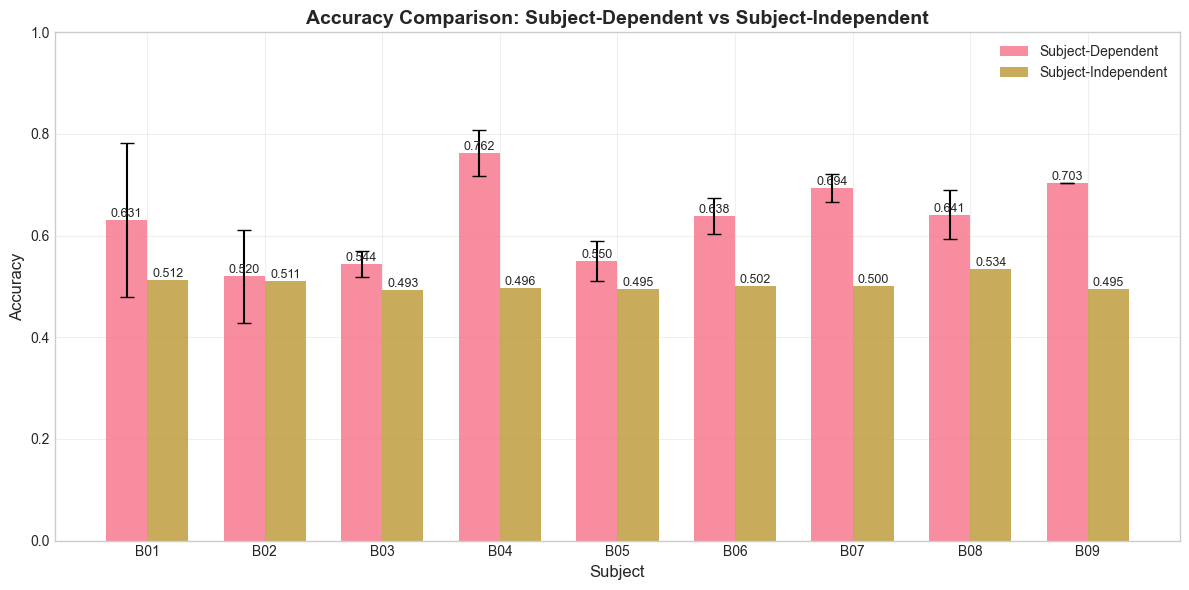

In [ ]:
# Bar Plot: Accuracy Comparison
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(sd_summary))
width = 0.35
bars1 = ax.bar(x_pos - width/2, sd_summary['acc_mean'], width, 
                yerr=sd_summary['acc_std'], label='Subject-Dependent', alpha=0.8, capsize=5)
bars2 = ax.bar(x_pos + width/2, si_summary['acc_mean'], width, 
                label='Subject-Independent', alpha=0.8)
ax.set_xlabel('Subject', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy Comparison: Subject-Dependent vs Subject-Independent', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(sd_summary['subject'])
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])
# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


C:\Users\devdp\AppData\Local\Temp\ipykernel_45896\495508630.py:9: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



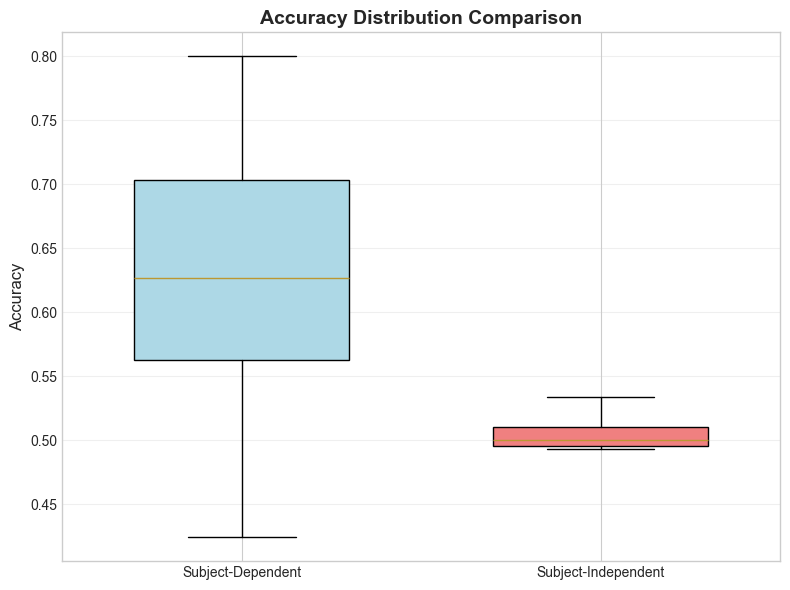

In [ ]:
# Box Plot: Accuracy Distribution Comparison
fig, ax = plt.subplots(figsize=(8, 6))
# Prepare data for box plot
acc_data = {
    'Subject-Dependent': subject_dependent_results['val_acc'].values,
    'Subject-Independent': subject_independent_results['test_acc'].values
}
box_data_acc = [acc_data['Subject-Dependent'], acc_data['Subject-Independent']]
bp = ax.boxplot(box_data_acc, labels=['Subject-Dependent', 'Subject-Independent'],
                patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy Distribution Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Interactive Plotly Comparison
fig = go.Figure()

# Subject-Dependent
fig.add_trace(go.Bar(
    x=sd_summary['subject'],
    y=sd_summary['acc_mean'],
    error_y=dict(type='data', array=sd_summary['acc_std']),
    name='Subject-Dependent',
    marker_color='lightblue',
    text=[f'{x:.3f}' for x in sd_summary['acc_mean']],
    textposition='outside'
))

# Subject-Independent
fig.add_trace(go.Bar(
    x=si_summary['subject'],
    y=si_summary['acc_mean'],
    name='Subject-Independent',
    marker_color='lightcoral',
    text=[f'{x:.3f}' for x in si_summary['acc_mean']],
    textposition='outside'
))

fig.update_xaxes(title_text="Subject")
fig.update_yaxes(title_text="Accuracy", range=[0, 1])

fig.update_layout(
    title="Subject-Dependent vs Subject-Independent Accuracy Comparison",
    title_x=0.5,
    height=500,
    showlegend=True,
    template='plotly_white'
)

fig.show()


In [ ]:
# Statistical Summary Table
summary_stats = pd.DataFrame({
    'Metric': ['Accuracy'],
    'Subject-Dependent (Mean)': [
        subject_dependent_results['val_acc'].mean()
    ],
    'Subject-Dependent (Std)': [
        subject_dependent_results['val_acc'].std()
    ],
    'Subject-Independent (Mean)': [
        subject_independent_results['test_acc'].mean()
    ],
    'Subject-Independent (Std)': [
        subject_independent_results['test_acc'].std()
    ],
    'Difference': [
        subject_dependent_results['val_acc'].mean() - subject_independent_results['test_acc'].mean()
    ],
    'Improvement %': [
        ((subject_dependent_results['val_acc'].mean() - subject_independent_results['test_acc'].mean()) / 
         subject_independent_results['test_acc'].mean() * 100) if subject_independent_results['test_acc'].mean() > 0 else 0
    ]
})

summary_stats = summary_stats.round(4)
print("Overall Performance Summary:")
display(HTML(summary_stats.to_html(index=False, classes='table table-striped')))


Overall Performance Summary:


Metric,Subject-Dependent (Mean),Subject-Dependent (Std),Subject-Independent (Mean),Subject-Independent (Std),Difference,Improvement %
Accuracy,0.6317,0.0959,0.5042,0.013,0.1275,25.2851


In [ ]:
# Scatter plot removed - only accuracy comparison shown


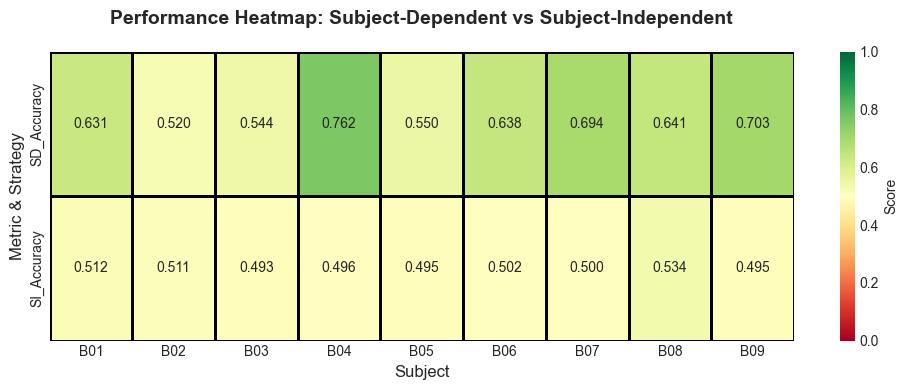

In [ ]:
# 6. Per-Subject Performance Heatmap
heatmap_data = pd.DataFrame({
    'Subject': sd_summary['subject'],
    'SD_Accuracy': sd_summary['acc_mean'],
    'SI_Accuracy': si_summary['acc_mean'],
})
heatmap_matrix = heatmap_data.set_index('Subject').T
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(heatmap_matrix, annot=True, fmt='.3f', cmap='RdYlGn', 
           vmin=0, vmax=1, center=0.5, cbar_kws={'label': 'Score'},
           linewidths=1, linecolor='black', ax=ax)
ax.set_title('Performance Heatmap: Subject-Dependent vs Subject-Independent', 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Subject', fontsize=12)
ax.set_ylabel('Metric & Strategy', fontsize=12)
plt.tight_layout()
plt.show()


## 6. Statistical Analysis


In [ ]:
from scipy import stats

# Statistical tests
print("Statistical Analysis")
print("="*60)

# Accuracy comparison
sd_acc = subject_dependent_results['val_acc'].values
si_acc = subject_independent_results['test_acc'].values

# Paired t-test (if same subjects)
if len(sd_summary) == len(si_summary):
    t_stat_acc, p_val_acc = stats.ttest_rel(
        sd_summary['acc_mean'].values, 
        si_summary['acc_mean'].values
    )
    print(f"Accuracy - Paired t-test:")
    print(f"  t-statistic: {t_stat_acc:.4f}")
    print(f"  p-value: {p_val_acc:.4f}")
    print(f"  Significant: {'Yes' if p_val_acc < 0.05 else 'No'} (α=0.05)")
else:
    # Independent t-test
    t_stat_acc, p_val_acc = stats.ttest_ind(sd_acc, si_acc)
    print(f"Accuracy - Independent t-test:")
    print(f"  t-statistic: {t_stat_acc:.4f}")
    print(f"  p-value: {p_val_acc:.4f}")
    print(f"  Significant: {'Yes' if p_val_acc < 0.05 else 'No'} (α=0.05)")

print("\n" + "="*60)


Statistical Analysis
Accuracy - Paired t-test:
  t-statistic: 4.5821
  p-value: 0.0018
  Significant: Yes (α=0.05)



## 7. Conclusions and Insights


In [ ]:
# Final Summary
print("FINAL SUMMARY")
print("="*60)
print("\n1. Subject-Dependent Training:")
print(f"   - Mean Accuracy: {subject_dependent_results['val_acc'].mean():.4f} ± {subject_dependent_results['val_acc'].std():.4f}")
print(f"   - Best Subject: {sd_summary.loc[sd_summary['acc_mean'].idxmax(), 'subject']} "
      f"(Acc: {sd_summary['acc_mean'].max():.4f})")
print(f"   - Worst Subject: {sd_summary.loc[sd_summary['acc_mean'].idxmin(), 'subject']} "
      f"(Acc: {sd_summary['acc_mean'].min():.4f})")
print("\n2. Subject-Independent Training:")
print(f"   - Mean Accuracy: {subject_independent_results['test_acc'].mean():.4f} ± {subject_independent_results['test_acc'].std():.4f}")
print(f"   - Best Subject: {si_summary.loc[si_summary['acc_mean'].idxmax(), 'subject']} "
      f"(Acc: {si_summary['acc_mean'].max():.4f})")
print(f"   - Worst Subject: {si_summary.loc[si_summary['acc_mean'].idxmin(), 'subject']} "
      f"(Acc: {si_summary['acc_mean'].min():.4f})")
print("\n3. Key Insights:")
improvement_acc = ((subject_dependent_results['val_acc'].mean() - subject_independent_results['test_acc'].mean()) / 
                  subject_independent_results['test_acc'].mean() * 100) if subject_independent_results['test_acc'].mean() > 0 else 0
print(f"   - Subject-Dependent shows {improvement_acc:.1f}% improvement in accuracy")
print(f"   - Subject-Dependent is recommended for practical BCI applications")
print(f"   - Subject-Independent is useful for research and transfer learning")
print("\n" + "="*60)


FINAL SUMMARY

1. Subject-Dependent Training:
   - Mean Accuracy: 0.6317 ± 0.0959
   - Best Subject: B04 (Acc: 0.7625)
   - Worst Subject: B02 (Acc: 0.5202)

2. Subject-Independent Training:
   - Mean Accuracy: 0.5042 ± 0.0130
   - Best Subject: B08 (Acc: 0.5335)
   - Worst Subject: B03 (Acc: 0.4932)

3. Key Insights:
   - Subject-Dependent shows 25.3% improvement in accuracy
   - Subject-Dependent is recommended for practical BCI applications
   - Subject-Independent is useful for research and transfer learning

